# Fitting Analysis, post FFTS


To begin we need to load in the data that we want to fit. Load in all of the FFTs for the condition that will be analyzed. We will then average the ROIs for the condition and then find the diffusion coefficient for each of the averaged ROI regions.


In [6]:
#Import all of the necessary packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.html.widgets import interact, fixed
import ipywidgets as widgets

import io

font_plt = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 10,
            }
font_plt_ax = {'family': 'serif',
               'color':  'black',
               'weight': 'normal',
               'size': 10,
              }
import sys
import glob #glob is helpful for searching for filenames or directories
import ddm_clean as ddm #this is the module containing the differential dynamic microscopy code
import scipy #scientific python
from scipy.signal import blackmanharris as bh #for Blackman-Harris windowing
import pickle #for saving data

import mpld3

In [7]:
allResults = {} #Initialize this at the very beginning. DON'T run every time. This is the storing mechanism

In [8]:
newt = lambda t,s: (1./s)*gamma(1./s)*t
framerate = 29.0
px = 0.194
imDimension = 256

In [9]:
### %matplotlib inline
#mpld3.enable_notebook()
# Change the directory or data file and change the condition number so the average ROI list can be iterated over
video = '1' #changes the video
roi = '256' #changes the ROI

data_dir = "D:\\" #data directory


data_file = "121818_lightsheet_29fps_34exp_"+video+"_MMStack_Pos0.ome_"+roi+"_256x256_FFTDIFFS_dts_ravs.p" #file you want to analyze

dat = pickle.load(open(data_dir + data_file,'rb'))
ravs = dat['ravs'] 
dts  = dat['dts']
ffts = dat['ffts']



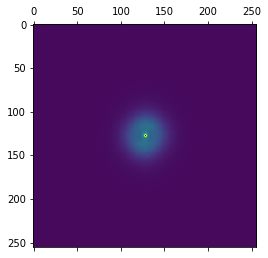

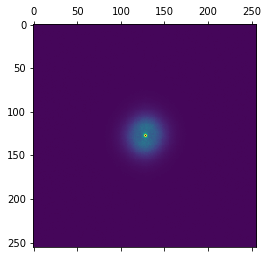

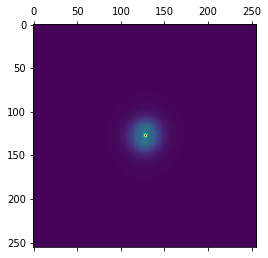

In [10]:
# If you want to check what the ffts look like get ride of the #s in front of :

plt.matshow(ffts[5])
plt.matshow(ffts[10])
plt.matshow(ffts[25])

# this will plot the fourier transform for a particular time point

Now we begin analysis: Going to find the background!

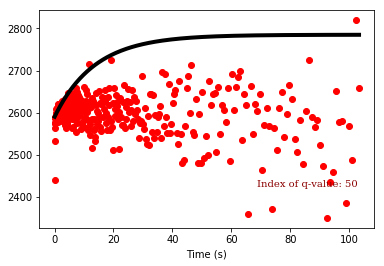

In [12]:
%matplotlib inline
mpld3.enable_notebook()

q = np.arange(0,imDimension/2)*2*np.pi*(1./(imDimension*px))

times = dts/framerate
q_index = 50
backg = 2590
#We try to use the function `returnReasonableParams` to find reasonable initial guesses for the fitting function

pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=ravs[:,q_index],bg=backg, double=False, fps=framerate)
plt.plot(times, ravs[:,q_index],'ro') #plot the data
plt.plot(times, ddm.dTheory(times,*pars), '-k', lw=4) #see how well the initial guess performs
ax = plt.gca()
plt.text(0.8, 0.2, 'Index of q-value: %i' % q_index, horizontalalignment='center', verticalalignment='center', 
           transform=ax.transAxes, fontdict=font_plt)
plt.xlabel('Time (s)');

This next function will plot fits for a few different q values, you should fix the background using the value you got above. Check fits with the plots 

mpfit.py:2284: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if numpy.rank(rr) != 2:


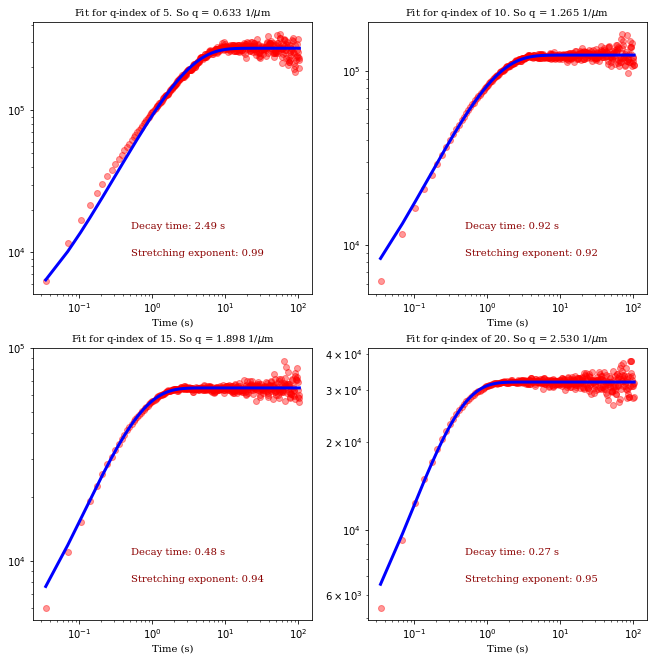

In [13]:

def two_rounds_fitting(data, times):
    '''
    This function does two rounds of fitting. 
    First it uses SciPy's least-squares fitting:
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html
    Then, it uses the Levenberg-Marquardt method with the mpfit module. 
    '''
    pars,minp,maxp,lmin,lmax,fix = ddm.returnReasonableParams(d=data, bg=backg, double=False, fps=framerate)
    #Paramters:
    # Amplitude-0, TimeConst-1, Background-2, Alpha (strtching exp), (... same for second exp..))
    
    #This is the streching exponent
    minp[3] = 0.6
    maxp[3] = 1.0
    pars[3] = 0.7
    
    #This is the background
    maxp[2] = 4100
    minp[2] = 100
    pars[2] = backg #this defines the background as what you found in the cell above
    
    maxp[1] = 10000
    minp[1] = 0.1
    
    maxp[5] = 100
    
    fix[3] = False
    fix[2] = True #this fixes the backgound
    
    minp[6] = 0.5
    maxp[6] = 1.0

    #The ddm.newFitLeastsq function does not check whether the parameters are within the
    #  minimum and maximum bounds. It uses SciPy's optimize.leastsq. 
    fitparams_lsq,theory_lsq = ddm.newFitLeastsq(data,times,pars,minp,maxp,lmin,lmax,fix,logfit=False)
    newPars = fitparams_lsq.copy()
    
    #We'll use the found parameters from SciPy's optimize.leastsq and feed them into the
    #  Levenberg-Marquardt function. Before we do so, we'll check that none of the found
    #  parameters are outside the min/max bounds. 
    for i,p in enumerate(fitparams_lsq):
        if p>maxp[i]:
            newPars[i] = maxp[i]*0.9
        if p<minp[i]:
            if p<0:
                newPars[i]=abs(p)
                if newPars[i]>maxp[i]:
                    newPars[i] = maxp[i]*0.9
                elif newPars[i]<minp[i]:
                    newPars[i] = minp[i]*1.1
            else:
                newPars[i] = minp[i]*1.1
                
    #Now use the Levenberg-Marquardt function. It returns the optimized paramters (fitparamsB), the 
    #  best fit (theoryB), any error codes, and the chi-squared value (the sum of squares of the error)
    fitparamsB, theoryB, errCodeB, chi2B = ddm.newFit(data,times,newPars,minp,maxp,lmin,lmax,fix,
                                                      logfit=False,quiet=True,factor=0.8)
    
    return fitparamsB, theoryB, chi2B

plt.figure(figsize=(11,11)) #Create figure of size 15x15 (inches)

q_index = 10
#Loop over four different q-values to do the fit
for i,q_index in enumerate([5,10,15,20]):
    fitparamsB, theoryB, chi2B = two_rounds_fitting(ravs[:,q_index], times)
    ax = plt.subplot(2,2,i+1) #creating 4 subplots in a 2x2 grid
    ax.loglog(times,ravs[:,q_index],'ro',alpha=0.4)
    ax.plot(times, theoryB, '-b',lw=3)
    ax.text(0.35,0.25,'Decay time: %.2f s' % fitparamsB[1], 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    ax.text(0.35,0.15,'Stretching exponent: %.2f' % fitparamsB[3], 
            fontdict=font_plt,horizontalalignment='left', 
            verticalalignment='center', transform=ax.transAxes)
    #ax.text(0.35,0.10,'Stretching exponent: %.2f' % fitparamsB[6], 
            #fontdict=font_plt,horizontalalignment='left', 
            #verticalalignment='center', transform=ax.transAxes)
    ax.set_xlabel("Time (s)", fontdict=font_plt_ax)
    ax.set_title("Fit for q-index of %i. So q = %.3f 1/$\mu$m" % (q_index, q[q_index]), fontdict=font_plt_ax)
    #ax.set_ylim(2.5e3,4.5e3)

If the fits look good for most or all then continue, if not then return and change initial parameters 

In [14]:
#Now, we'll do that fit for *all* q-values

#Initialize arrays to store the fit paramters
fitparams = np.zeros((ravs.shape[1],7))
theory = np.zeros((ravs.shape[1],len(times)))
tau = np.zeros_like(ravs[0,:]) #decay time
amp = np.zeros_like(tau) #amplitude
bg = np.zeros_like(tau) #background
alph = np.zeros_like(tau) #alpha (stretching exponent)
amp2 = np.zeros_like(tau) #amplitude
tau2 = np.zeros_like(tau) #background
alph2 = np.zeros_like(tau) #alpha (stretching exponent)
chi2 = np.zeros_like(tau)
for i in range(1,len(tau)):
    fitparams[i], theory[i], chi2[i] = two_rounds_fitting(ravs[:,i], times)
    amp[i] = fitparams[i][0]
    bg[i] = fitparams[i][2]
    tau[i] = fitparams[i][1]
    alph[i] = fitparams[i][3]
    amp2[i] = fitparams[i][4]
    tau2[i] = fitparams[i][5]
    alph2[i] = fitparams[i][6]

ddm_clean.py:243: RuntimeWarning: invalid value encountered in power
  g1 = np.exp(-1 * (x / t1)**s1)
C:\Users\Rohwer Lab\Anaconda2\lib\site-packages\scipy\optimize\minpack.py:447: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


After all the fits are calculated then continue on and plot the decay times verses the spatial frequencies ( the important information )

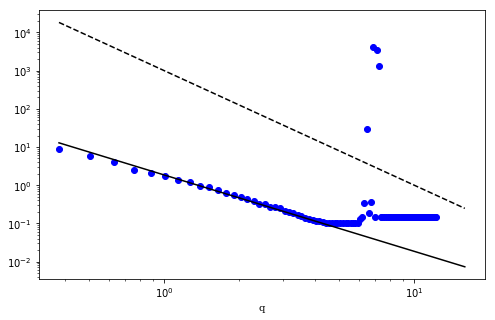

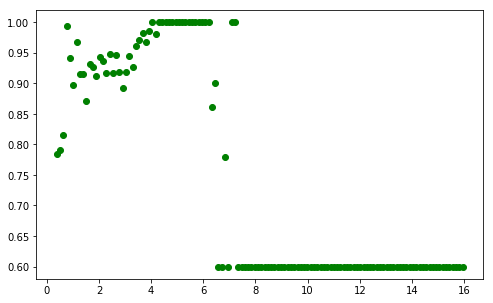

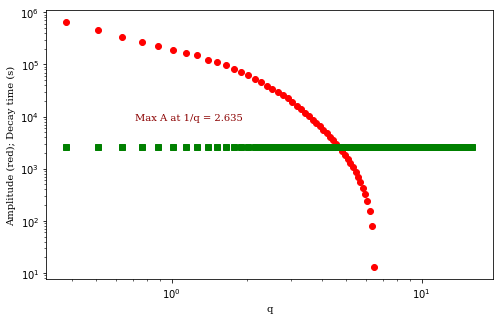

In [18]:
#Plot the decay time versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.loglog(q[3:-30], ddm.newt(tau[2:-30],alph[2:-30]),'bo')
diffusion_coeff = 0.54
ax.plot(q[3:-1], (1./diffusion_coeff) * 1./(q[3:-1]**2), '-k')
adiffusion_coeff = 0.001
ax.plot(q[3:-1], (1./adiffusion_coeff) * 1./(q[3:-1]**3), '--k')
ax.set_xlabel("q", fontdict=font_plt_ax)

fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.plot(q[3:-1],alph[2:-1],'go')

#Plot the amplitude versus the wave vector
fig = plt.figure(figsize=(8,8/1.618)); ax = fig.gca(); 
ax.loglog(q[3:-1], amp[2:-1], 'ro')
#ax.loglog(q[3:-1], amp2[2:-1], 'rv')
w = amp[2:-1].argmax() #argmax returns the index of the array that has the max value
q_for_max_a = q[3:-1][w]
ax.loglog(q[3:-1], bg[2:-1], 'gs') #Plot the background versus the wave vector
ax.set_xlabel("q", fontdict=font_plt_ax)
ax.set_ylabel("Amplitude (red); Decay time (s)", fontdict=font_plt_ax)
ax.text(0.2,0.6,'Max A at 1/q = %.3f' % (1.0/q_for_max_a), 
        fontdict=font_plt,horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes);

In [22]:
allResults['fitparams_'+roi] = fitparams
allResults['theory_'+roi] = theory
allResults['chi2_'+roi] = chi2
allResults['dts'] = dts

In [23]:
allResults.keys()

['fitparams_256', 'dts', 'chi2_256', 'theory_256']

After you have analyzed all of the videos you want to save the dictionary file allResults below

In [24]:
pickle.dump(allResults, open("D:\\All_results_4252019_test.p", 'wb'))

In [25]:
a = pickle.load(open("D:\\All_results_4252019_test.p",'rb'))

In [26]:
a.keys()

['fitparams_256', 'dts', 'chi2_256', 'theory_256']